# Cluster Characterization

This notebook trains an Artificial Neural Network for cluster characterization.

## Initial settings

In [1]:
from cdalvaro.catalogues import OpenClust
from cdalvaro.data_base import DB
from cdalvaro.graphics import plot as cplt
from cdalvaro.logging import Logger
from cdalvaro.ml import DEC
from cdalvaro.ml.utils import estimate_n_clusters, filter_outliers
from IPython.display import Image
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from keras.initializers import glorot_uniform, VarianceScaling
from keras.optimizers import SGD
from keras.utils import plot_model

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_hd_-_firepro_d700.1"


In [2]:
logger = Logger.instance()
logger.setLevel(logging.ERROR)

db = DB.instance(host='gaia.cdalvaro.io', port=15432)

figures_path = "../../figures"
save_dir = '../../results'

clusters = OpenClust.catalogue()

## Feature selection

In [3]:
variables = [
    "ra", "ra_error", "dec", "dec_error", "pmra", "pmra_error",
    "pmdec", "pmdec_error", "parallax", "parallax_error",
    "phot_g_mean_mag", "bp_rp"
]

non_null_columns = list(filter(lambda x: not re.search(r'_error', x), variables))

## Stars selection

In [4]:
cluster = clusters["Melotte 22"]
stars_df = db.get_stars(region=cluster, columns=variables, filter_null_columns=non_null_columns)

stars_df = stars_df[(np.abs(stars_df['pmra']) > 0.0)
                    & (np.abs(stars_df['pmdec']) > 0.0)
                    & (np.abs(stars_df['parallax']) > 0.0)]

stars_df['pmra_corr'] = stars_df['pmra'] * 1000.0 / stars_df['parallax']
stars_df['pmdec_corr'] = stars_df['pmdec'] * 1000.0 / stars_df['parallax']

stars_df['pmmod'] = np.sqrt(stars_df['pmra_corr'] ** 2 + stars_df['pmdec_corr'] ** 2)
stars_df['pmang'] = np.arctan2(stars_df['pmdec_corr'], stars_df['pmra_corr'])

stars_df.head()

ra  ra_error        dec  dec_error  \
region_id source_id                                                      
302       64035217900973056  56.965683  0.731908  22.636288   0.455961   
          64035217900973440  56.957961  0.344281  22.631481   0.216900   
          64035217901215616  56.966256  0.904192  22.632545   0.525417   
          64035351043566208  56.917301  0.166422  22.626708   0.103046   
          64035385403304960  56.925461  0.546319  22.634953   0.311519   

                                 pmra  pmra_error     pmdec  pmdec_error  \
region_id source_id                                                        
302       64035217900973056  2.848682    1.711448 -3.291204     1.115977   
          64035217900973440  0.894901    0.804658 -3.445501     0.523968   
          64035217901215616  7.924372    2.124344 -0.241281     1.378156   
          64035351043566208 -4.433802    0.372218 -2.584965     0.231818   
          64035385403304960  0.055990    1.334990 -1.760018     0.757478   

                             parallax  parallax_error  phot_g_mean_mag  \
region_id source_id                                                      
302       64035217900973056 -0.854332        0.799045        20.090477   
          64035217900973440  0.336814        0.382097        19.032112   
          64035217901215616 -0.990431        1.025846        20.290981   
          64035351043566208 -0.080650        0.193725        17.814991   
          64035385403304960  0.138322        0.599870        19.578548   

                                bp_rp     pmra_corr    pmdec_corr  \
region_id source_id                                                 
302       64035217900973056  1.341768  -3334.397284   3852.371739   
          64035217900973440  1.704838   2656.958416 -10229.676916   
          64035217901215616  1.651123  -8000.928819    243.611562   
          64035351043566208  1.016489  54975.852052  32051.647600   
          64035385403304960  1.114752    404.784211 -12724.083913   

                                    pmmod     pmang  
region_id source_id                                  
302       64035217900973056   5094.994923  2.284246  
          64035217900973440  10569.092574 -1.316681  
          64035217901215616   8004.636692  3.111154  
          64035351043566208  63636.879423  0.527836  
          64035385403304960  12730.520872 -1.538995

## Feature selection

In [5]:
features = ['pmra_corr', 'pmdec_corr', 'pmmod', 'parallax']

## Feature rescaling

In [6]:
scaler = MinMaxScaler()
x = scaler.fit_transform(stars_df[features])

## K-Means

In [7]:
## Step 1 - Creating and training K-means model
n_clusters, kmeans = estimate_n_clusters(x, min_clusters=5, max_clusters=5, verbose=True)
stars_df['cluster_g'] = np.array([f"g{g}" for g in kmeans.predict(x)], dtype=str)

Silhouette score for 5 clusters: 0.5613
Best silhouette score is 0.5613 for 5 clusters


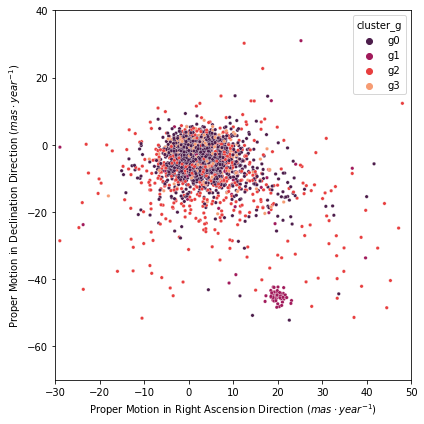

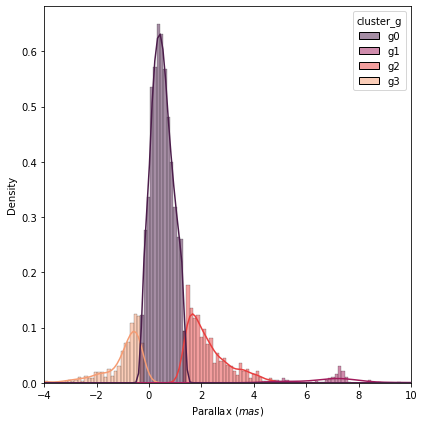

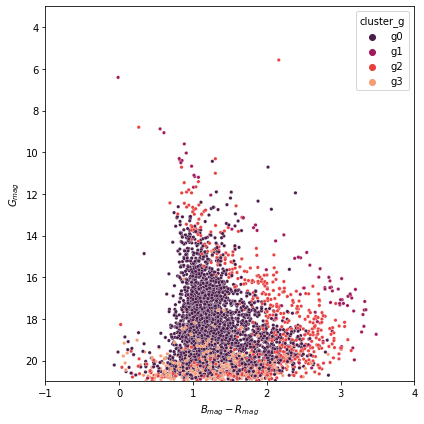

In [8]:
fig, ax, g = cplt.plot_cluster_proper_motion(stars_df, xlim=(-30, 50), ylim=(-70, 40))
cplt.save_figure(fig, name=f"kmeans_pm_{cluster.name}", save_dir=figures_path)

fig, ax, g = cplt.plot_cluster_parallax_histogram(stars_df, xlim=(-4, 10), stat='density')
cplt.save_figure(fig, name=f"kmeans_parallax_{cluster.name}", save_dir=figures_path)

fig, ax, g = cplt.plot_cluster_isochrone_curve(stars_df, xlim=(-1, 4), ylim=(3, 21))
cplt.save_figure(fig, name=f"kmeans_isochrone_{cluster.name}", save_dir=figures_path)

In [9]:
stars_df['cluster_g'].value_counts()

g0    35507
g2     9540
g3     5948
g1     1386
g4        1
Name: cluster_g, dtype: int64

# Deep Embedded Clustering (DEC)

https://arxiv.org/pdf/1511.06335.pdf


In [10]:
# Reference:
#     Unsupervised Deep Embedding for Clustering Analysis - 4.3 Implementation
# dims = [x.shape[-1], 500, 500, 2000, 10]
dims = [x.shape[-1], 50, 50, 200, n_clusters]

loss = 'kld'
optimizer = SGD(1, 0.9)
init = VarianceScaling(scale=1.0/3.0, mode='fan_in', distribution='uniform', seed=11)
#init = glorot_uniform(seed=1)

# DEC model
dec = DEC(dims=dims, n_clusters=n_clusters, initializer=init)
dec.compile(optimizer=optimizer, loss=loss)
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
encoder_0 (Dense)            (None, 50)                250       
_________________________________________________________________
encoder_1 (Dense)            (None, 50)                2550      
_________________________________________________________________
encoder_2 (Dense)            (None, 200)               10200     
_________________________________________________________________
encoder_3 (Dense)            (None, 5)                 1005      
_________________________________________________________________
clustering (ClusteringLayer) (None, 5)                 25        
Total params: 14,030
Trainable params: 14,030
Non-trainable params: 0
_________________________________________________________________


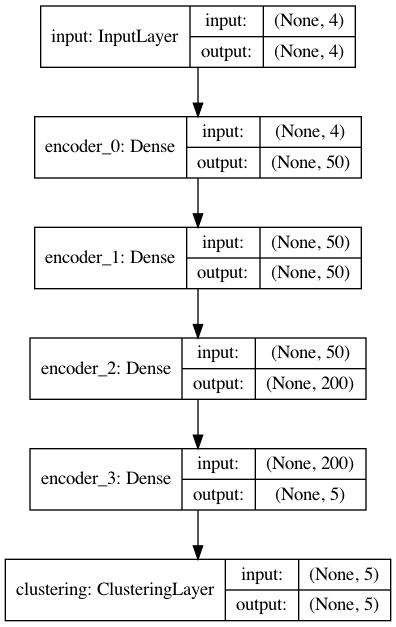

In [11]:
plot_model(dec.model, to_file=f'{save_dir}/dec_model.png', show_shapes=True)
Image(filename=f'{save_dir}/dec_model.png')

In [12]:
# Training parameters
epochs = 30
batch_size = 128
maxiter = 2000
update_interval = 20
verbose = 1

dec.pretrain(x, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
dec.fit(x, batch_size=batch_size, maxiter=maxiter, update_interval=update_interval, verbose=verbose)

Pretraining autoencoder model...
Epoch 1/30
52382/52382 [==============================] - 3s 58us/step - loss: 0.0031
Epoch 2/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.3934e-04
Epoch 3/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.4000e-04
Epoch 4/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.4076e-04
Epoch 5/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.4007e-04
Epoch 6/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.3992e-04
Epoch 7/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.4047e-04
Epoch 8/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.4018e-04
Epoch 9/30
52382/52382 [==============================] - 3s 53us/step - loss: 1.3934e-04
Epoch 10/30
52382/52382 [==============================] - 3s 54us/step - loss: 1.4025e-04
Epoch 11/30
52382/52382 [==============================] - 3s 54us/ste

In [13]:
stars_df['cluster_g'] = np.array([f"g{g}" for g in dec.predict(x)], dtype=str)
stars_df['cluster_g'].value_counts()

g3    49771
g1     1689
g2      878
g0       32
g4       12
Name: cluster_g, dtype: int64

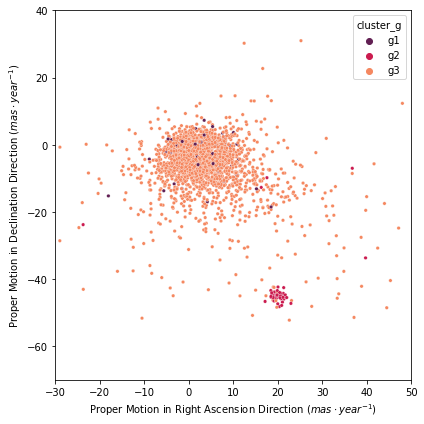

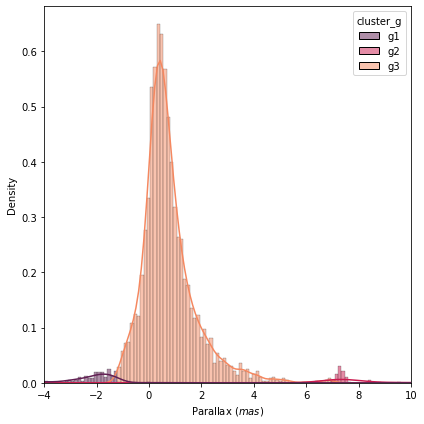

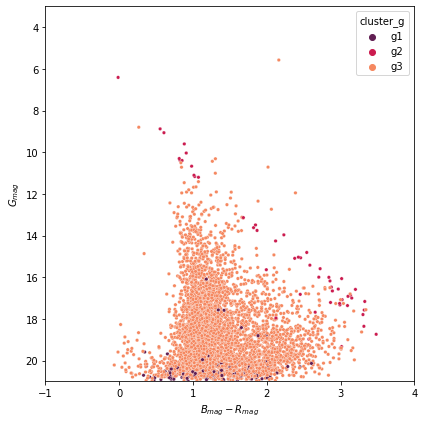

In [14]:
fig, ax, g = cplt.plot_cluster_proper_motion(stars_df, xlim=(-30, 50), ylim=(-70, 40))
cplt.save_figure(fig, name=f"dec_pm_{cluster.name}", save_dir=figures_path)

fig, ax, g = cplt.plot_cluster_parallax_histogram(stars_df, xlim=(-4, 10), stat='density')
cplt.save_figure(fig, name=f"dec_parallax_{cluster.name}", save_dir=figures_path)

fig, ax, g = cplt.plot_cluster_isochrone_curve(stars_df, xlim=(-1, 4), ylim=(3, 21))
cplt.save_figure(fig, name=f"dec_isochrone_{cluster.name}", save_dir=figures_path)

In [15]:
filtered_df = None
q = 0.25
for i in [f"g{x}" for x in range(n_clusters)]:
    df = stars_df[stars_df['cluster_g'] == i]
    mask = filter_outliers(df['parallax'], q)
    if filtered_df is None:
        filtered_df = df[mask]
    else:
        filtered_df = pd.concat([filtered_df, df[mask]])

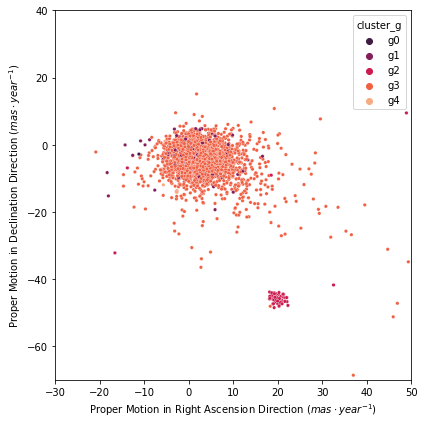

In [16]:
fig, ax, g = cplt.plot_cluster_proper_motion(filtered_df, xlim=(-30, 50), ylim=(-70, 40))
cplt.save_figure(fig, name=f"dec_pm_{cluster.name}_filtered", save_dir=figures_path)